In [1]:
%matplotlib inline
import cv2
import numpy as np

from matplotlib import pyplot as plt

In [2]:
def zmMinFilterGray(src, r=7):
    '''最小值滤波，r是滤波器半径'''
    '''if r <= 0:
        return src
    h, w = src.shape[:2]
    I = src
    res = np.minimum(I  , I[[0]+range(h-1)  , :])
    res = np.minimum(res, I[range(1,h)+[h-1], :])
    I = res
    res = np.minimum(I  , I[:, [0]+range(w-1)])
    res = np.minimum(res, I[:, range(1,w)+[w-1]])
    return zmMinFilterGray(res, r-1)'''
    return cv2.erode(src, np.ones((2*r+1, 2*r+1)))                      #使用opencv的erode函数更高效

In [3]:
def guidedfilter(I, p, r, eps):
    '''引导滤波，直接参考网上的matlab代码'''
    height, width = I.shape
    m_I = cv2.boxFilter(I, -1, (r,r))
    m_p = cv2.boxFilter(p, -1, (r,r))
    m_Ip = cv2.boxFilter(I*p, -1, (r,r))
    cov_Ip = m_Ip-m_I*m_p
  
    m_II = cv2.boxFilter(I*I, -1, (r,r))
    var_I = m_II-m_I*m_I
  
    a = cov_Ip/(var_I+eps)
    b = m_p-a*m_I
  
    m_a = cv2.boxFilter(a, -1, (r,r))
    m_b = cv2.boxFilter(b, -1, (r,r))
    return m_a*I+m_b

In [4]:
def getV1(m, r, eps, w, maxV1):  #输入rgb图像，值范围[0,1]
    '''计算大气遮罩图像V1和光照值A, V1 = 1-t/A'''
    V1 = np.min(m,2)                                         #得到暗通道图像
    V1 = guidedfilter(V1, zmMinFilterGray(V1,7), r, eps)     #使用引导滤波优化
    bins = 2000
    ht = np.histogram(V1, bins)                              #计算大气光照A
    d = np.cumsum(ht[0])/float(V1.size)
    for lmax in range(bins-1, 0, -1):
        if d[lmax]<=0.999:
            break
    A  = np.mean(m,2)[V1>=ht[1][lmax]].max()
          
    V1 = np.minimum(V1*w, maxV1)                   #对值范围进行限制
      
    return V1,A

In [5]:
def deHaze(m, r=81, eps=0.001, w=0.95, maxV1=0.80, bGamma=False):
    Y = np.zeros(m.shape)
    V1,A = getV1(m, r, eps, w, maxV1)               #得到遮罩图像和大气光照
    for k in range(3):
        Y[:,:,k] = (m[:,:,k]-V1)/(1-V1/A)           #颜色校正
    Y =  np.clip(Y, 0, 1)
    if bGamma:
        Y = Y**(np.log(0.5)/np.log(Y.mean()))       #gamma校正,默认不进行该操作
    return Y

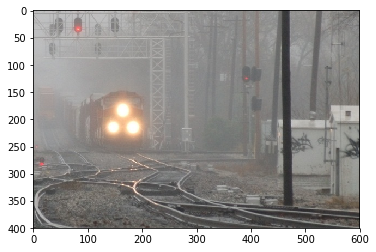

In [15]:
if __name__ == '__main__':
#     改进这处代码，让他在这个地方显示图片对比
#     m = deHaze(cv2.imread('train.jpg')/255.0)*255
    sourceImg = cv2.imread('train.jpg')
    deHazeimg = deHaze(sourceImg/255.0)*255
    
#     手动转换
#     bs, gs, rs = cv2.split(sourceImg)
#     b, g, r = cv2.split(deHazeimg)
    
#     srcImage_new = cv2.merge([rs, gs, bs])
# 由于OpenCV读取图像的通道是BGR，而Matplotlib的通道是RGB，需要转换，调用cv2.cvtColor()，如下：
    srcImage_new = cv2.cvtColor(sourceImg, cv2.COLOR_BGR2RGB)
#     deHazeimg_new = cv2.merge([r, g, b])
    
    
    plt.imshow(srcImage_new)
#     plt.imshow(deHazeimg_new)
#     cv2.imwrite('defog2.jpg', m)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


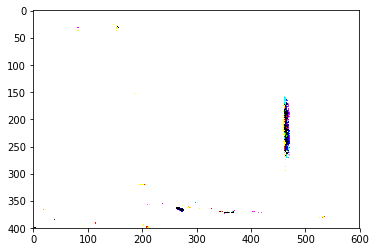

In [8]:
plt.imshow(deHazeimg_new)